# Salifort Motors: Analyzing Employee Data for Improved Retention
## 1. Introduction
### 1.1 Problem
Currently, there is a high rate of turnover among Salifort employees. Salifort’s senior leadership team is concerned about how many employees are leaving the company. Salifort strives to create a corporate culture that supports employee success and professional development. Further, the high turnover rate is costly in the financial sense. Salifort makes a big investment in recruiting, training, and upskilling its employees. 

If Salifort could predict whether an employee will leave the company, and discover the reasons behind their departure, they could better understand the problem and develop a solution. 

### 1.2 Objectives
The primary objectives for this project is to
1. Build a robust predictive model that can accurately forecast whether an employee is likely to leave the company. This model will serve as a valuable tool for the HR department to proactively address potential turnover risks.
2. Analyze the data to identify the key factors that significantly influence employee attrition. By understanding these factors, Salifort Motors can implement targeted strategies to improve employee satisfaction and retention.
3.  Provide data-driven and actionable insights to the HR department, enabling them to make informed decisions to foster a positive work environment and address employee concerns effectively.

### 1.3 About the Dataset
The dataset that contains 15,000 rows and 10 columns for the variables listed below. 

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

## 2. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pickle

In [2]:
df = pd.read_csv('dataset/HR_dataset.csv')

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### 2.1 Rename columns
Standardize the column names so that they are all in snake_case, correct any column names that are misspelled, and make column names more concise as needed.

In [3]:
df = df.rename(columns={
    'Work_accident': 'work_accident',
    'average_montly_hours': 'average_monthly_hours',
    'time_spend_company': 'tenure',
    'Department': 'department'
})

df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### 2.2 Check missing values

In [4]:
df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_monthly_hours    False
tenure                   False
work_accident            False
left                     False
promotion_last_5years    False
department               False
salary                   False
dtype: bool

There is no missing value in the dataset.

### 2.3 Check duplicates

In [5]:
duplicate_count = df.duplicated().sum()
duplicate_percent = round(duplicate_count / len(df) * 100)

print(f'{duplicate_count} rows contain duplicates ({duplicate_percent}% of entire dataset).')

3008 rows contain duplicates (20% of entire dataset).


In [6]:
df = df.drop_duplicates(keep='first')

## 3. Exploratory Data Analysis (EDA)

### 3.1 Descriptive statistics

In [7]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### 3.2 Checks outliers

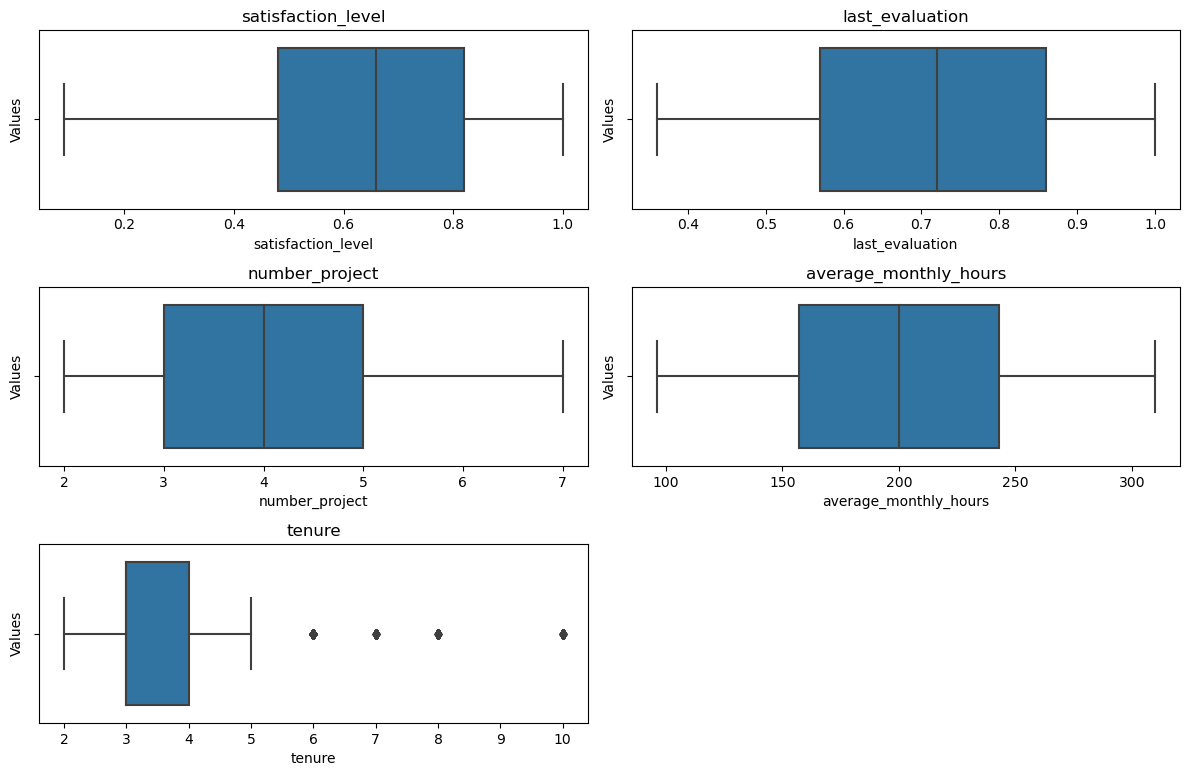

In [8]:
plt.figure(figsize=(12, 10))

for i, col in enumerate(['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

The boxplot above shows that there are outliers in the `tenure` variable. It would be helpful to investigate how many rows in the data contain outliers in the tenure column.

In [9]:
# compute the 25th percentile
percentile25 = df['tenure'].quantile(0.25)

# compute the 75th percentile
percentile75 = df['tenure'].quantile(0.75)

# compute the interqurtile range
iqr = percentile75 - percentile25

# define upper and lower limit for non-outlier values
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print(f'Lower Limit: {lower_limit}')
print(f'Upper Limit: {upper_limit}')

# identify subset of data contains outliers
outliers = df[(df['tenure'] > upper_limit) | (df['tenure'] < lower_limit)]
print(f'Number of rows in the data containing outliers in `tenure`: {len(outliers)}')

Lower Limit: 1.5
Upper Limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


### 3.3 Distribution of target variable (`left`)

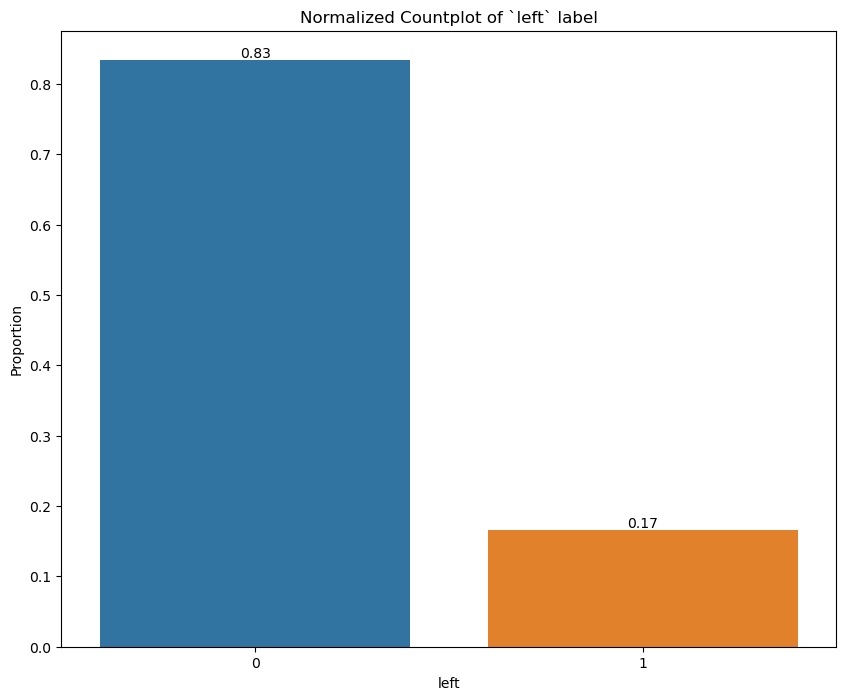

In [13]:
pct_left = df['left'].value_counts(normalize=True)

plt.figure(figsize=(10, 8))

ax = sns.barplot(x=pct_left.index, y=pct_left.values)
plt.title('Normalized Countplot of `left` label')
plt.xlabel('left')
plt.ylabel('Proportion')

for index, value in enumerate(pct_left.values):
    ax.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

### 3.4 Analysis
We start by creating a stacked boxplot showing `average_monthly_hours` distributions for `number_project`, comparing the distributions of employees who stayed versus those who left.

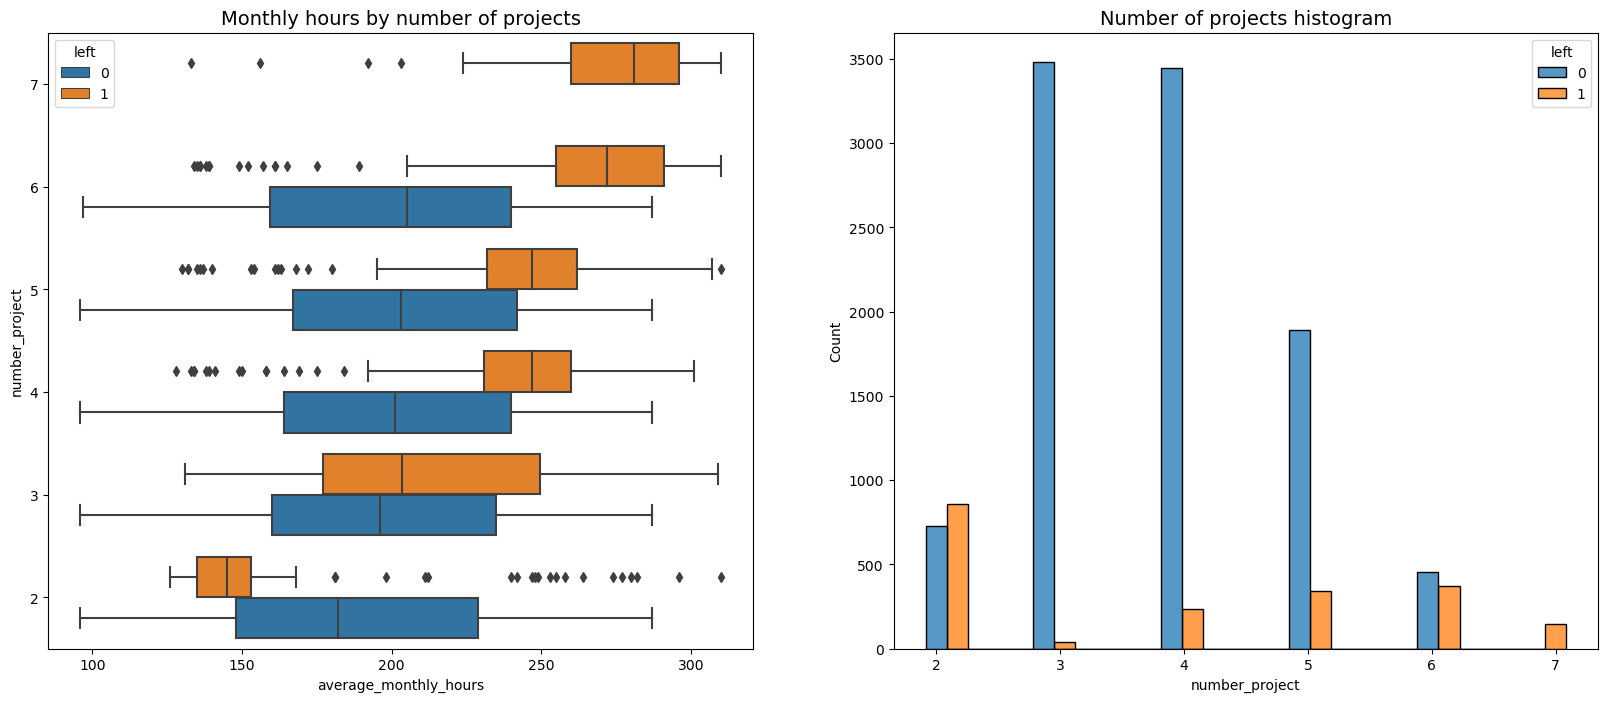

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))

sns.boxplot(data=df, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

sns.histplot(data=df, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()

A few things stand out from the plot:
1. There are two groups of employees that left the company. (A) those who worked considerably less than their peers with the same number of projects, and (B) those who worked much more. In group A, it's possible that they are fired, or employees who had already given their notice and were assigned fewer hours because they were already on their way out the door. For those in group B, it's reasonable to infer that they probably quit.
2. Everyone with seven projects left the company, and the interquartile ranges of this group and those who left with six projects was ~255–295 hours/week—much more than any other group.
3. The optimal number of projects for employees seems to be 3-5. The ratio of left/stayed is very small for these cohorts.
4. The average number of working hours per month of employees working `Monday–Friday = 50 weeks * 40 hours per week / 12 months = 166.67 hours per month`. This means that, aside from the employees who worked on two projects, every group—even those who didn't leave the company—worked considerably more hours than this. It seems that employees here are overworked.

Next, we examine the relationship between `average_monthly_hours` and `satisfaction_level`.

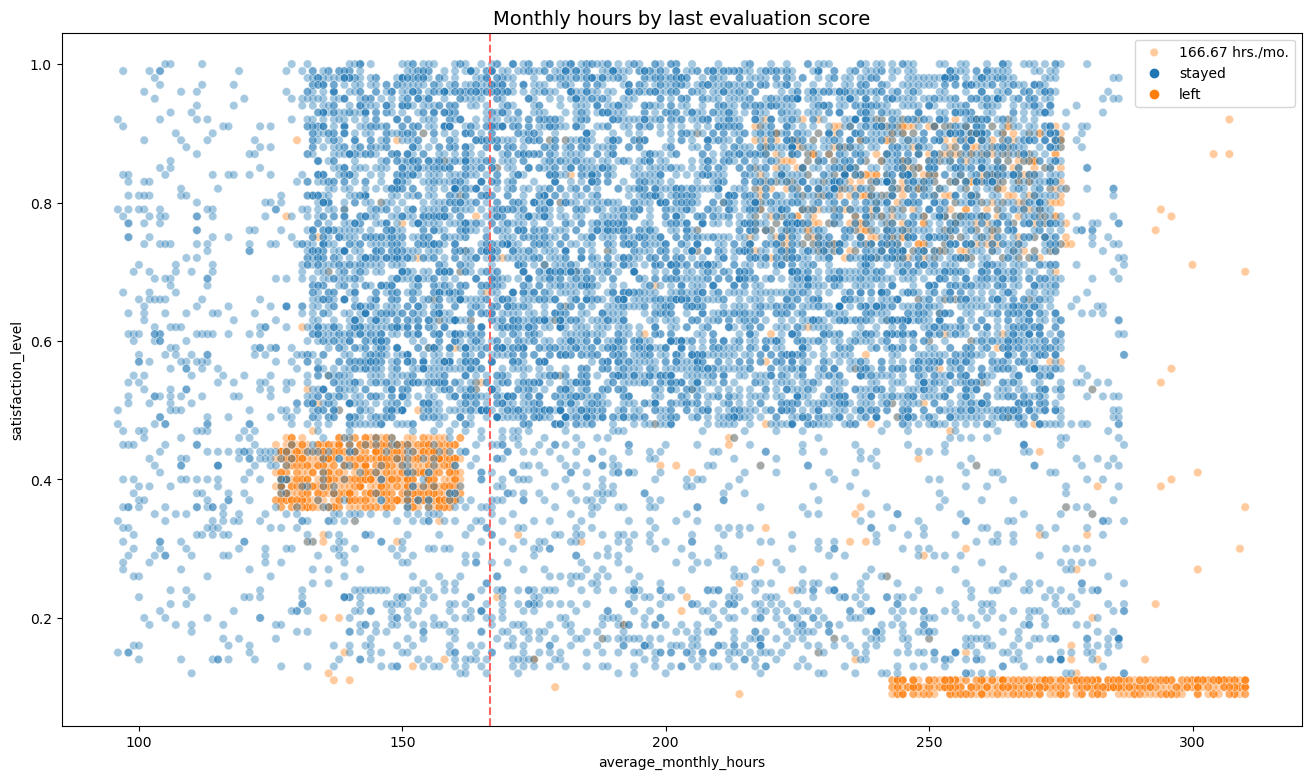

In [14]:
plt.figure(figsize=(16, 9))

sns.scatterplot(data=df, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by last evaluation score', fontsize='14')

plt.show()

The scatterplot above shows that there was a sizeable group of employees who worked ~240–315 hours per month. 315 hours per month is over 75 hours per week for a whole year. It's likely this is related to their satisfaction levels being close to zero.

The plot also shows another group of people who left, those who had more normal working hours. Even so, their satisfaction was only around 0.4. It's difficult to speculate about why they might have left. It's possible they felt pressured to work more, considering so many of their peers worked more. And that pressure could have lowered their satisfaction levels.

Finally, there is a group who worked ~210–280 hours per month, and they had satisfaction levels ranging ~0.7–0.9.

Next, we can visualize satisfaction levels by tenure.

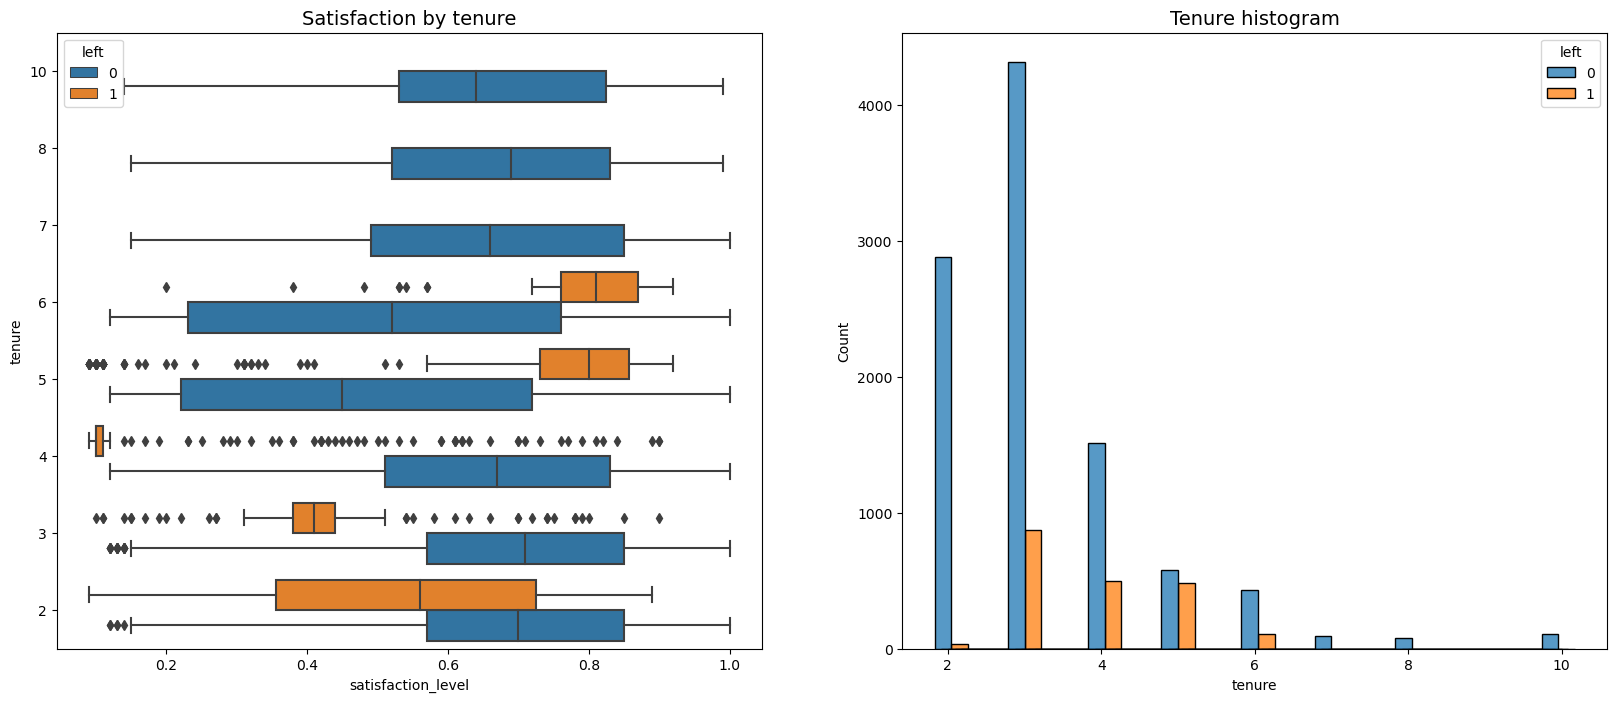

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))

sns.boxplot(data=df, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

sns.histplot(data=df, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show()

Some observations that can be made from the plot:
1. Employees who left fall into two general categories: dissatisfied employees with shorter tenures and very satisfied employees with medium-length tenures.
2. Four-year employees who left seem to have an unusually low satisfaction level.
3. The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed.

As the next step, we calculate and visualize the mean and median satisfaction scores of employees who left and those who didn't.

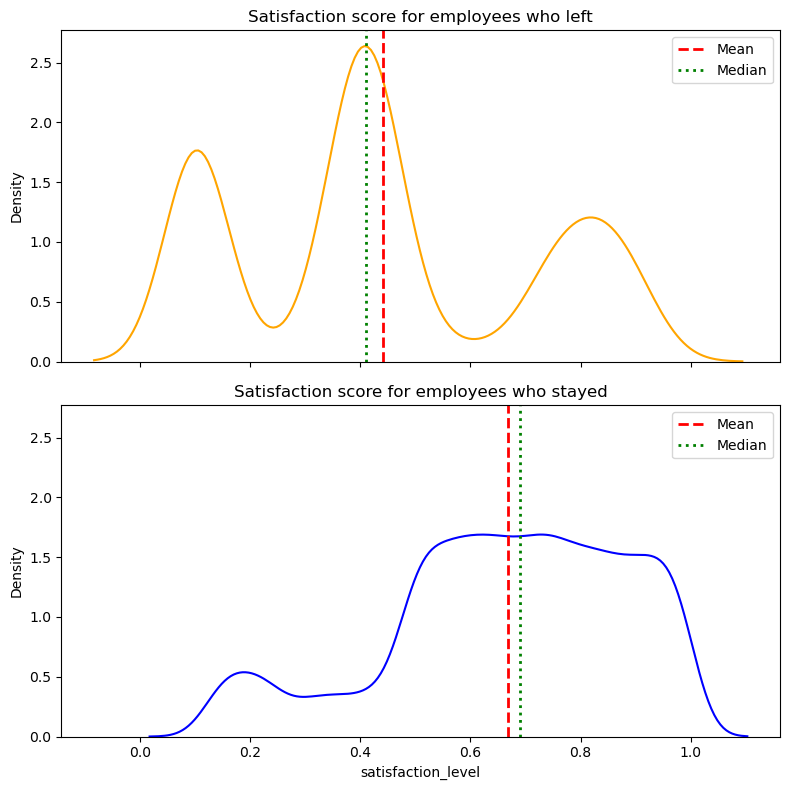

In [16]:
left_0 = df[df['left'] == 0]['satisfaction_level']
left_1 = df[df['left'] == 1]['satisfaction_level']

mean_left_0 = left_0.mean()
mean_left_1 = left_1.mean()
median_left_0 = left_0.median()
median_left_1 = left_1.median()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

sns.kdeplot(data=left_1, color='orange', ax=ax1)
ax1.axvline(mean_left_1, color='red', linestyle='dashed', linewidth=2, label="Mean")
ax1.axvline(median_left_1, color='green', linestyle='dotted', linewidth=2, label="Median")
ax1.set_xlabel("Value")
ax1.set_ylabel("Density")
ax1.set_title("Satisfaction score for employees who left")
ax1.legend()

sns.kdeplot(data=left_0, color='blue', ax=ax2)
ax2.axvline(mean_left_0, color='red', linestyle='dashed', linewidth=2, label="Mean")
ax2.axvline(median_left_0, color='green', linestyle='dotted', linewidth=2, label="Median")
ax2.set_ylabel("Density")
ax2.set_title("Satisfaction score for employees who stayed")
ax2.legend()

plt.tight_layout()
plt.show()

As expected, the mean and median satisfaction scores of employees who left are lower than those of employees who stayed. Among employees who stayed, the mean satisfaction score appears to be slightly below the median score, indicating that satisfaction levels among those who stayed skewed to the left.

Next, we examine whether employees who worked very long hours were promoted in the last five years.

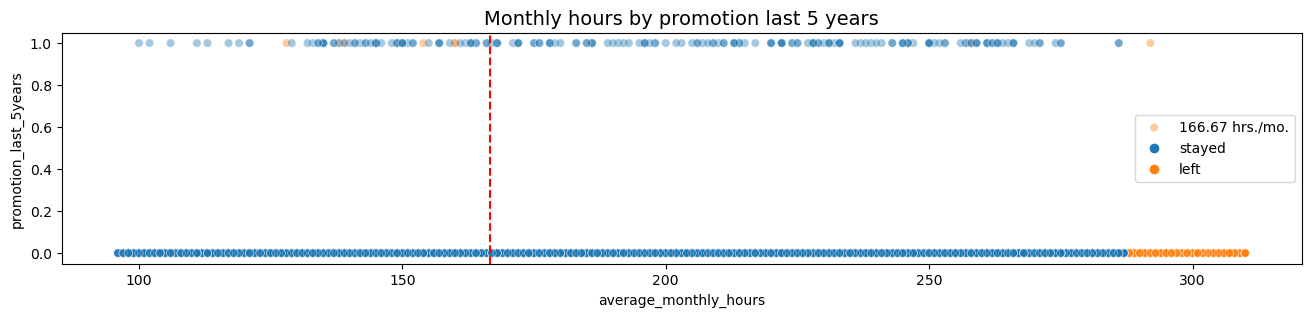

In [17]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='red', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14')

plt.show()

The plot above shows the following:
1. Very few employees who were promoted in the last five years left
2. Very few employees who worked the most hours were promoted
3. Most of the employees who left were working the longest hours

Next, we inspect how the employees who left are distributed across departments.

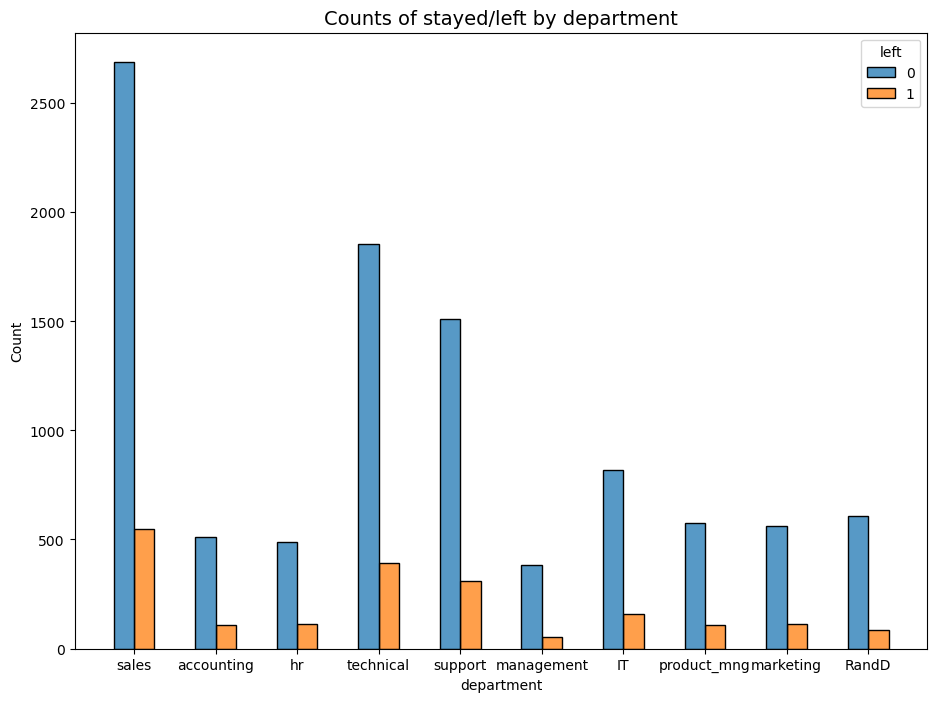

In [18]:
plt.figure(figsize=(11,8))
sns.histplot(data=df, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.title('Counts of stayed/left by department', fontsize=14)

plt.show()

There doesn't seem to be any department that differs significantly in its proportion of employees who left to those who stayed.

Lastly, we use heatmap to check for strong correlations between variables in the data.

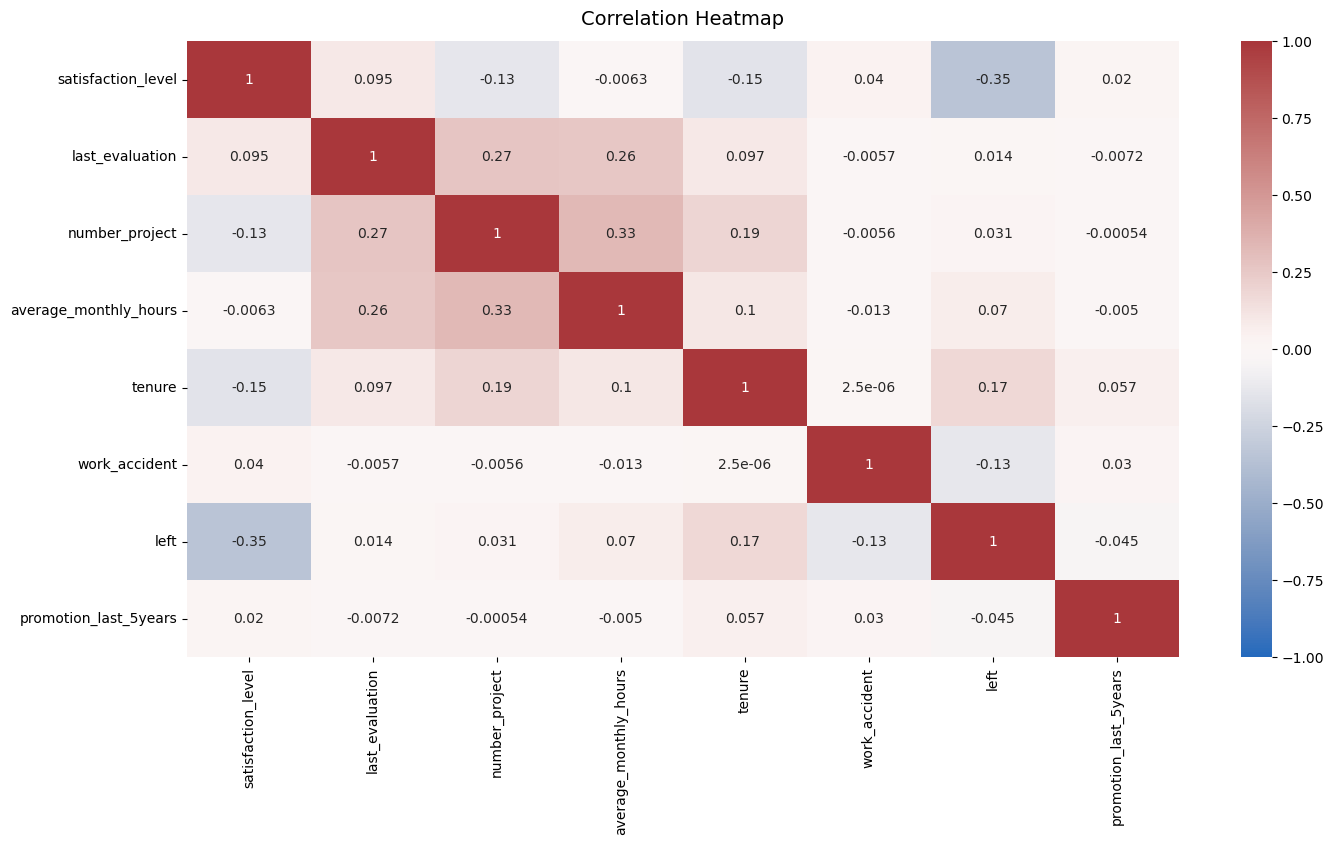

In [21]:
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)

plt.show()

The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

### 3.5 Insights
It appears that employees are leaving the company as a result of poor management. Leaving is tied to longer working hours, many projects, and generally lower satisfaction levels. It can be ungratifying to work long hours and not receive promotions or good evaluation scores. There's a sizeable group of employees at this company who are probably burned out. It also appears that if an employee has spent more than six years at the company, they tend not to leave.

## 4. Model Building

### 4.1 Helper functions

In [28]:
def plot_cm_and_report(model, X_test, y_test):
    """
    Plot the confusion matrix and print the classification report for a given model.

    Parameters:
        model (object): the trained model (e.g., logistic regression, random forest, etc.).
        X_test (array-like): the test feature dataset.
        y_test (array-like): the true labels for the test feature dataset.

    Returns:
        None
    """
    # make predictions using the model
    y_pred = model.predict(X_test)

    # calculate the confusion matrix and display it with ConfusionMatrixDisplay
    model_cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    model_disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels=model.classes_)
    model_disp.plot(values_format='')

    plt.grid(False)
    plt.show()

    # print the classification report
    target_names = ['Predicted would not leave', 'Predicted would leave']
    print(classification_report(y_test, y_pred, target_names=target_names))

### 4.2 Feature Engineering
Upon analyzing the dataset, we have identified two features that may be susceptible to data leakage: `satisfaction_level` and `average_monthly_hours`. The `satisfaction_level` feature could potentially introduce data leakage as the company might not have reported satisfaction levels for all employees. This could result in missing data, leading to biased model predictions. Another potential source of data leakage is the `average_monthly_hours` feature. Employees who have already decided to quit or are flagged for termination may exhibit reduced work hours, skewing the distribution and introducing bias in the dataset. As so, we need to drop the `satisfaction_level` and `average_monthly_hours` features, and create a new feature `overwork`. We define being overworked as working more than 175 hours per month on average.

In [22]:
df['overwork'] = (df['average_monthly_hours'] > 175).astype(int)

df = df.drop(columns=['satisfaction_level', 'average_monthly_hours'])

df.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,department,salary,overwork
0,0.53,2,3,0,1,0,sales,low,0
1,0.86,5,6,0,1,0,sales,medium,1
2,0.88,7,4,0,1,0,sales,medium,1
3,0.87,5,5,0,1,0,sales,low,1
4,0.52,2,3,0,1,0,sales,low,0


#### 4.3 Model 0: Baseline
We need to determined the baseline accuracy the model needs to beat.

In [23]:
acc_baseline = round(df['left'].value_counts(normalize=True).max(), 2)

acc_baseline

0.83

#### 4.4 Model 1: Logistic Regression Model
First, we need to encode the non-numeric variables `department` and `salary`. `department` is a categorical variable, which means we can dummy it for modeling. `salary` is categorical too, but it's ordinal. There's a hierarchy to the categories, so it's better not to dummy this column, but rather to convert the levels to numbers, 0–2.

In [24]:
df_enc = df.copy()

df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

df_enc = pd.get_dummies(df_enc, drop_first=False)

df_enc.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,overwork,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,6,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
2,0.88,7,4,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
3,0.87,5,5,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


Since logistic regression is quite sensitive to outliers, we need to remove the outlier in the `tenure` columns that were identified earlier.

In [25]:
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

df_logreg.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,overwork,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.88,7,4,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0
3,0.87,5,5,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0.50,2,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [26]:
y = df_logreg['left']
X = df_logreg.drop('left', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [27]:
log_clf = LogisticRegression(random_state=42, max_iter=1000)
log_clf.fit(X_train, y_train)

log_clf

LogisticRegression(max_iter=1000, random_state=42)

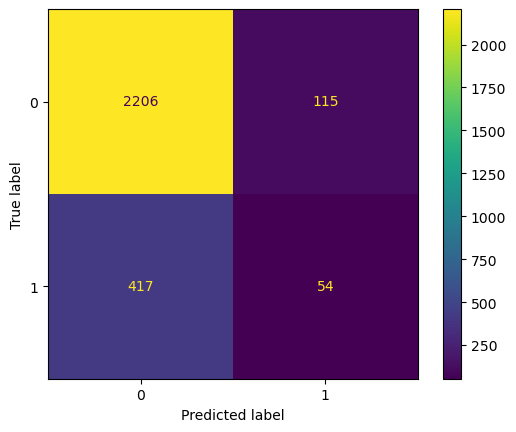

                           precision    recall  f1-score   support

Predicted would not leave       0.84      0.95      0.89      2321
    Predicted would leave       0.32      0.11      0.17       471

                 accuracy                           0.81      2792
                macro avg       0.58      0.53      0.53      2792
             weighted avg       0.75      0.81      0.77      2792



In [30]:
plot_cm_and_report(model=log_clf, X_test=X_test, y_test=y_test)

The upper-left quadrant displays the number of true negatives. The upper-right quadrant displays the number of false positives. The bottom-left quadrant displays the number of false negatives. The bottom-right quadrant displays the number of true positives.

- True negatives: The number of people who did not leave that the model accurately predicted did not leave.

- False positives: The number of people who did not leave the model inaccurately predicted as leaving.

- False negatives: The number of people who left that the model inaccurately predicted did not leave

- True positives: The number of people who left the model accurately predicted as leaving

The classification report above shows that the logistic regression model achieved a precision of 79%, recall of 82%, f1-score of 80% (all weighted averages), and accuracy of 82%.

#### 4.5 Model 2: Decision Tree
We construct a decision tree model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [31]:
tree_clf = DecisionTreeClassifier(random_state=42)

cv_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [2, 5, 1],
    'min_samples_split': [2, 4, 6]
}

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

grid_search = GridSearchCV(tree_clf, cv_params, scoring=scoring, cv=5, refit='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'f1', 'recall', 'roc_auc', 'accuracy', 'precision'})

In [32]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 6}

In [33]:
grid_search.best_score_

0.9611374117419906

In [34]:
best_tree_clf = grid_search.best_estimator_

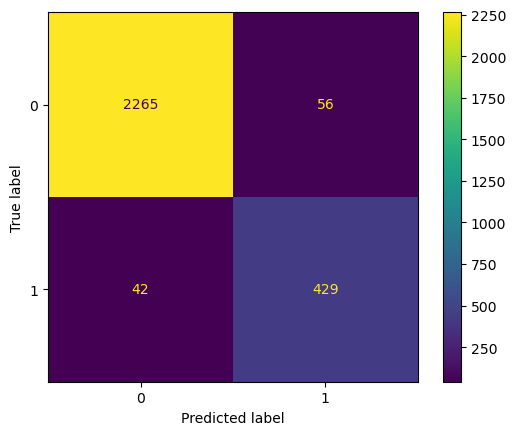

                           precision    recall  f1-score   support

Predicted would not leave       0.98      0.98      0.98      2321
    Predicted would leave       0.88      0.91      0.90       471

                 accuracy                           0.96      2792
                macro avg       0.93      0.94      0.94      2792
             weighted avg       0.97      0.96      0.97      2792



In [35]:
plot_cm_and_report(model=best_tree_clf, X_test=X_test, y_test=y_test)

The classification report above shows that the decision tree model achieved a precision of 97%, recall of 96%, f1-score of 97% (all weighted averages), and accuracy of 96%. As the accuracy of the decision tree model exceed the baseline and the logistic regression model, we decide to choose this model for production.

### 4.6 Feature Importances

In order to gain insights into the factors influencing employee attrition, we conducted a feature importance analysis using our predictive model. This analysis aims to identify the most influential features that contribute to the prediction of employee attrition, providing valuable insights for the company's retention strategies.

In [37]:
importances = pd.DataFrame(best_tree_clf.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
importances = importances.sort_values(by='gini_importance', ascending=False)

importances = importances[importances['gini_importance'] != 0]
importances

,gini_importance
tenure,0.309673
number_project,0.302218
last_evaluation,0.298575
overwork,0.085192
department_technical,0.002329
salary,0.000815
department_IT,0.000483
department_sales,0.000398
department_support,0.000262
work_accident,0.000055


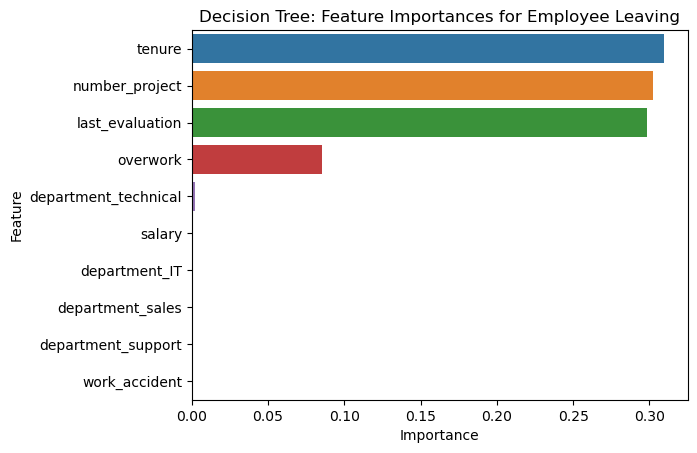

In [38]:
sns.barplot(data=importances, x="gini_importance", y=importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The feature importance plot above shows that `tenure`, `number_project`, `last_evaluation`, and `overwork` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`.

## 5. Conclusion and Recommendations
The models and the feature importances extracted from the models confirm that employees at the company are overworked.

To retain employees, we recommend the following:
1. Cap the number of projects that employees can work on.
2. Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied.
3. Either reward employees for working longer hours, or don't require them to do so.
4. If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear.
5. High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort.